# Broadcast Setting 

## Input a given Network


In [23]:
import numpy as np
import sys
from random import choices #For randomized policy
from statistics import mean 
import tqdm.notebook
import matplotlib.pyplot as plt

In [19]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: problems found:
        - require?  X jupyter-js-widgets/extension


In [2]:
import ipykernel
import ipywidgets
import IPython
import jupyter
import notebook
import tqdm
import tqdm.notebook
import widgetsnbextension

In [3]:
# A 3 x 3 grid

N= 9
A= np.zeros((N,N));
Key_rate= np.zeros((N,N));  #Expected Key Arrival Rate
C_tilde = np.zeros((N,N));


A[0][1]=1;
A[0][3]=1;
A[1][2]=1;
A[1][4]=1;
A[2][5]=1;
A[3][4]=1;
A[3][6]=1;
A[4][5]=1;
A[4][7]=1;
A[5][8]=1;
A[6][7]=1;
A[7][8]=1;

Key_rate[0][1]=0.5;
Key_rate[0][3]=0.5;
Key_rate[1][2]=0.5;
Key_rate[1][4]=0.5;
Key_rate[2][5]=0.5;
Key_rate[3][4]=0.5;
Key_rate[3][6]=0.5;
Key_rate[4][5]=0.5;
Key_rate[4][7]=0.5;
Key_rate[5][8]=0.5;
Key_rate[6][7]=0.5;
Key_rate[7][8]=0.5;

start = 0; dest = 8

lamb = 0.5

In [4]:
n = N   #Number of Nodes
T = 1000 #Number of time slots of running

m = 0  #Counting number of edges
E = [] #Storing as adjacency list of edges

#Constructing Adjacency list and C_tilde matrix for capacity
for i in range(N):
    for j in range(N):
        if(A[i][j]!=0):
            m = m+1
            E.append([i,j,A[i][j],Key_rate[i][j]])
        C_tilde[i][j] = min(A[i][j],Key_rate[i][j])

In [5]:
lamb

0.5

In [6]:
lamb=lamb*0.95

## Finding minimum spanning tree
We use prim's algorithm on a graph with edge weights given by $\tilde{Q}_e(t)$

In [7]:
#Prims algo

def prims(V, start, G):

    vertex = start
    MST = []
    edges = []
    visited = []
    minEdge = [None,None, 1000000]

    while (1):
        visited.append(vertex)
        
        for i in range(len(G)):
            if(G[i][0]==vertex):
                edges.append(G[i])
        for e in range(0, len(edges)):
            if edges[e][2] < minEdge[2] and edges[e][1] not in visited:
                minEdge = edges[e]
                
        if(minEdge not in edges):
            break
        else:
            edges.remove(minEdge)
            MST.append(minEdge)
            vertex = minEdge[1]
            minEdge = [None,None,1000000]

    return MST


In [9]:
class packet:
    def __init__(self,i,t, r, d):
        self.index = i
        self.time = t
        self.route = r
        self.dist = d
        
from collections import deque

class Queue():  #A FIFO queue

    def __init__(self, max_size = sys.maxsize):
        self._queue = deque(maxlen=max_size)
        self.size = 0
        
    def isEmpty(self):
        return self.size == 0
    
    def returnLen(self):
        return self.size 

    def enqueue(self, item):
        self._queue.append(item)
        self.size = self.size + 1

    def dequeue(self):
        if (self.size > 0):
            self.size = self.size - 1
            return self._queue.pop()          
        else:
            return (-1)

In [10]:
def route_edge_set(route):
    route_edge = []
    for j in range (len(route)):
        for i in range(m):
            if(E[i][0]==route[j][0] and E[i][1]==route[j][1]):
                route_edge.append(i)
    return route_edge

No handles with labels found to put in legend.


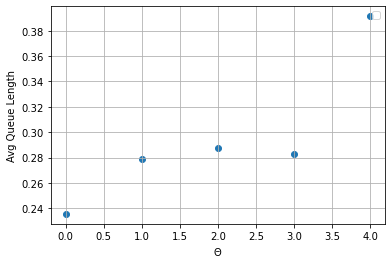

In [140]:
Q_m=[]
for i in range(5):
    Q_m.append(mean(Thresh_Q[i]))
plt.scatter(np.arange(5), Q_m)
plt.xlabel("$\Theta$")
plt.ylabel("Avg Queue Length")
plt.legend()
plt.grid()
plt.show()

## Broadcast APM

We set a threshold $\Theta$ such that a link is active only when sufficient keys are present

In [30]:
def Broadcast_APM(T, arr, key_arr, thresh):
    
    Q = np.zeros(m)   #Virtual Queue
    Q_sum = np.zeros(T)
    S = np.zeros(m)  #Actual Keys at each Edge
    S_v = np.zeros(m)  #Virtual Keys at each edge
    sum_arr = 0

    # Variables for recording the statistics 
    sum_Q_len=0
    avg_Q_len= np.zeros((1,T))

    # Number of current packet entered into the network
    Packet_index=0

    Phy_Q = []   #These are m queues for edges 
    for i in range(m):
        obj = Queue()
        Phy_Q.append(obj)

    V = Queue()  #Temporary storage at source
    #Storing the packet when min-cut of keys is 0, we will only use one V in single commodity case
    V_len = 0
    V_len_arr = np.zeros(T)

    for t in range(T):
        a=arr[t]       # Arrival to the source 
        sum_arr=sum_arr+a
        #Assuming Poisson Key Generation Process
        for i in range(m):
            K = key_arr[i][t]
            S[i] = S[i] + K
            S_v[i] = S_v[i] + K

        #Setting the weight of our graph whose min path is to be computed
        # as the length of 1virtual queues 
        G = []
        for i in range(m):
            if(S_v[i] >= thresh):
                G.append([E[i][0],E[i][1], Q[i]])  

        for j in range(a):
            p = [0,t,None,0]
            V.enqueue(p) 
            V_len = V_len +1

        route = prims(N, start, G)
        #Converting route as sequence of nodes to sequence of edges
        if(len(route) == N-1):
            route_edge = route_edge_set(route)
            y = min(V_len, thresh)
            for i in range(y):
                V_len = V_len-1
                packet = V.dequeue()
                packet[2] = route
                for k in range(len(route_edge)):
                    if(route[k][0]==start):
                        Phy_Q[route_edge[k]].enqueue(packet)

            for i in range(len(route_edge)):
                Q[route_edge[i]] = Q[route_edge[i]] + y
                S_v[route_edge[i]] = S_v[route_edge[i]] - y

        Phy_Q_len=[]
        for u in range(m):
            Phy_Q_len.append(Phy_Q[u].returnLen())

        # Physical Queue Updation
        obj = []
        for i in range(m):
            obj.append(Phy_Q[i].dequeue())  #Assuming service process is limited to 1 packet per slot
        
        for i in range(m):        
            if(obj[i]!=-1):
                cur_edge = i
                route_p = obj[i][2] #Getting next node of packet in the route
                route_p_edge = route_edge_set(route_p)
                next_edges=[]
                for j in range(len(route_p)):
                    if (route_p[j][0] == E[i][1]):
                        next_edges.append(route_p_edge[j])
                
                #Key Availability Constraint
                for k in range(len(next_edges)):                   
                    Phy_Q[next_edges[k]].enqueue(obj[i])
                    
            if(Q[i]>0):
                Q[i] = Q[i]-1 #Updating Virtual Queues

        V_len_arr[t] = V_len

        for i in range(m): 
            Q_sum[t] = Q_sum[t] + Phy_Q[i].returnLen()
        
        Q_sum[t] = Q_sum[t] + V_len
        Q_sum[t] = Q_sum[t]/m
        
    return(Q_sum)


In [11]:
G = []
for i in range(m):
    G.append([E[i][0],E[i][1],0])  

route = prims(N, start, G)

In [12]:
route

[[0, 1, 0],
 [0, 3, 0],
 [1, 2, 0],
 [1, 4, 0],
 [3, 6, 0],
 [2, 5, 0],
 [4, 7, 0],
 [5, 8, 0]]

## TQD

In [25]:
def TQD(T, arr, key_arr):
    
    Qv1 = np.zeros(m)   #Virtual Queue 1
    Qv2 = np.zeros(m)   #Virtual Queue 2
    
    Q_sum = np.zeros(T)
    S = np.zeros(m)  #Actual Keys at each Edge
    sum_arr = 0

    Q1 = []   #These are m queues for edges 
    Q2 = [] 
    for i in range(m):
        obj1 = Queue()
        obj2 = Queue()
        Q1.append(obj1)
        Q2.append(obj2)

    for t in range(T):
        a=arr[t]       # Arrival to the source 
        sum_arr=sum_arr+a
        #Assuming Poisson Key Generation Process
        for i in range(m):
            K = key_arr[i][t]
            S[i] = S[i] + K

        #Setting the weight of our graph whose min path is to be computed
        # as the length of 1virtual queues 
        G = []
        for i in range(m):
            G.append([E[i][0],E[i][1], Qv1[i]+Qv2[i]])  

        route = prims(N, start, G)
        #Converting route as sequence of nodes to sequence of edges
     
        route_edge = route_edge_set(route)
        
        for i in range(len(route_edge)):
            Qv1[route_edge[i]] = Qv1[route_edge[i]] + a
            Qv2[route_edge[i]] = Qv2[route_edge[i]] + a
            
        for j in range(a):
            p = [0,t,route,0]
            for k in range(len(route_edge)):
                if(route[k][0]==start):
                    Q1[route_edge[k]].enqueue(p)

        # Physical Queue Updation
        obj = []
        for i in range(m):
            for j in range(key_arr[i][t]):
                g = Q1[i].dequeue()
                if(g!= -1):
                    Q2[i].enqueue(g)
            obj.append(Q2[i].dequeue())  #Assuming service process is limited to 1 packet per slot
        
            #Updating Virtual Queues        
            if(Qv2[i]>0):
                Qv2[i] = Qv2[i]-1 
                
            Qv1[i] = Qv1[i]-key_arr[i][t]
            if(Qv1[i]<0):
                Qv1[i] = 0
                
        for i in range(m):        
            if(obj[i]!=-1):
                cur_edge = i
                route_p = obj[i][2] #Getting next node of packet in the route
                route_p_edge = route_edge_set(route_p)
                next_edges=[]
                for j in range(len(route_p)):
                    if (route_p[j][0] == E[i][1]):
                        next_edges.append(route_p_edge[j])
                
                #Key Availability Constraint
                for k in range(len(next_edges)):                   
                    Q1[next_edges[k]].enqueue(obj[i])
                    
        for i in range(m): 
            Q_sum[t] = Q_sum[t] + Q1[i].returnLen() + Q2[i].returnLen()
        
        Q_sum[t] = Q_sum[t]/m
        
    return(Q_sum)


## TQD with storage

In [33]:
def TQS(T, arr, key_arr):
    
    Qv1 = np.zeros(m)   #Virtual Queue 1
    Qv2 = np.zeros(m)   #Virtual Queue 2
    
    Q_sum = np.zeros(T)
    S = np.zeros(m)  #Actual Keys at each Edge
    sum_arr = 0

    Q1 = []   #These are m queues for edges 
    Q2 = [] 
    for i in range(m):
        obj1 = Queue()
        obj2 = Queue()
        Q1.append(obj1)
        Q2.append(obj2)

    for t in range(T):
        a=arr[t]       # Arrival to the source 
        sum_arr=sum_arr+a
        #Assuming Poisson Key Generation Process
        for i in range(m):
            K = key_arr[i][t]
            S[i] = S[i] + K

        #Setting the weight of our graph whose min path is to be computed
        # as the length of 1virtual queues 
        G = []
        for i in range(m):
            G.append([E[i][0],E[i][1], Qv1[i]+Qv2[i]])  

        route = prims(N, start, G)
        #Converting route as sequence of nodes to sequence of edges
     
        route_edge = route_edge_set(route)
        
        for i in range(len(route_edge)):
            Qv1[route_edge[i]] = Qv1[route_edge[i]] + a
            Qv2[route_edge[i]] = Qv2[route_edge[i]] + a
            
        for j in range(a):
            p = [0,t,route,0]
            for k in range(len(route_edge)):
                if(route[k][0]==start):
                    Q1[route_edge[k]].enqueue(p)

        # Physical Queue Updation
        obj = []
        for i in range(m):
            
            used_key_count = 0
            for j in range(int(S[i])):
                g = Q1[i].dequeue()
                if(g!= -1):
                    Q2[i].enqueue(g)
                    used_key_count = used_key_count + 1
            obj.append(Q2[i].dequeue())  #Assuming service process is limited to 1 packet per slot
        
            #Update key count
            S[i] = S[i] - used_key_count 
            
            #Updating Virtual Queues        
            if(Qv2[i]>0):
                Qv2[i] = Qv2[i]-1 
                
            Qv1[i] = Qv1[i]-key_arr[i][t]
            if(Qv1[i]<0):
                Qv1[i] = 0
                
        for i in range(m):        
            if(obj[i]!=-1):
                cur_edge = i
                route_p = obj[i][2] #Getting next node of packet in the route
                route_p_edge = route_edge_set(route_p)
                next_edges=[]
                for j in range(len(route_p)):
                    if (route_p[j][0] == E[i][1]):
                        next_edges.append(route_p_edge[j])
                
                #Key Availability Constraint
                for k in range(len(next_edges)):                   
                    Q1[next_edges[k]].enqueue(obj[i])
                    
        for i in range(m): 
            Q_sum[t] = Q_sum[t] + Q1[i].returnLen() + Q2[i].returnLen()
        
        Q_sum[t] = Q_sum[t]/m
        
    return(Q_sum)


## Simulations

In [35]:
T=1000

Thresh_Q = []

arr = np.random.poisson(0.9*lamb, T)  #Poisson arrival storing

key_arr = []
for i in range(m):
    key_arr.append(np.random.poisson(E[i][3], T))
    
Q1_sum =TQD(T, arr, key_arr)
Q2_sum =Broadcast_APM(T, arr, key_arr,2)
Q3_sum =TQS(T, arr, key_arr)

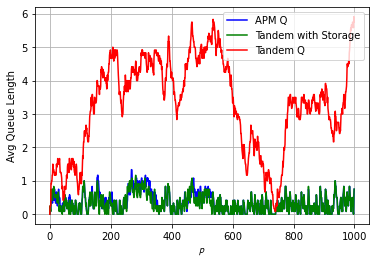

In [36]:
import matplotlib.pyplot as plt

plt.plot(Q2_sum, color = 'blue', label = 'APM Q')
plt.plot(Q3_sum, color = 'green', label = 'Tandem with Storage')
plt.plot(Q1_sum, color = 'red', label = 'Tandem Q')

#plt.plot(Q4_sum, color = 'orange', label = 'BP')

plt.xlabel("$\mathcal{p}$")
plt.ylabel("Avg Queue Length")
plt.grid()
plt.legend()
plt.show()

In [39]:
from tqdm import tqdm
T=800 
num = 100
points = 20
prec = 0.05

Thresh_Q = []
Thresh_V = []

apm_q_len = []
Heur_q_len = []


sum_apm = np.zeros(points+1)
sum_bp = np.zeros(points+1)
sum_tq = np.zeros(points+1)
sum_ts = np.zeros(points+1)
sum_rand = np.zeros(points+1)
sum_dynam = np.zeros(points+1)


for j in tqdm(range(num)):
    for p in tqdm(range(points+1)):  
        #The threshold that determines whether there is minimum that many keys in each edge. Should try thresh = max(c_e)

        arr = np.random.poisson(prec*p*lamb, T)  #Poisson arrival storing

        key_arr = []
        for i in range(m):
            key_arr.append(np.random.poisson(E[i][3], T))

        #apm_mean = mean(AssurePath(T, arr, key_arr,2))
        tq_mean = mean(TQD(T,arr,key_arr))
        ts_mean = mean(TQS(T,arr,key_arr))
        #bp_mean = mean(BP(T,arr,key_arr))
        #rand_mean = mean(Randomized(T,arr,key_arr))
        #dynam_mean = mean(dynamic(T,arr,key_arr))

        #sum_apm[p] = sum_apm[p] + apm_mean
        #sum_bp[p] = sum_bp[p] + bp_mean
        sum_tq[p] = sum_tq[p] + tq_mean
        sum_ts[p] = sum_ts[p] + ts_mean
        #sum_rand[p] = sum_rand[p] + rand_mean
        #sum_dynam[p] = sum_dynam[p] + dynam_mean

 86%|██████████████████████████████████████████████████████████████████████▎           | 18/21 [00:28<00:04,  1.57s/it]


 71%|██████████████████████████████████████████████████████████▌                       | 15/21 [00:22<00:08,  1.43s/it]


 57%|██████████████████████████████████████████████▊                                   | 12/21 [00:19<00:13,  1.52s/it]


 43%|███████████████████████████████████▌                                               | 9/21 [00:13<00:17,  1.48s/it]


 29%|███████████████████████▋                                                           | 6/21 [00:05<00:12,  1.19it/s]


 14%|███████████▊                                                                       | 3/21 [00:02<00:15,  1.13it/s]


  0%|                                                                                           | 0/21 [00:00<?, ?it/s]


 95%|██████████████████████████████████████████████████████████████████████████████    | 20/21 [00:16<00:00,  1.29it/s]


 81%|██████████████████████████████████████████████████████████████████▍               | 17/21 [00:14<00:03,  1.24it/s]


 67%|██████████████████████████████████████████████████████▋                           | 14/21 [00:11<00:05,  1.18it/s]


 52%|██████████████████████████████████████████▉                                       | 11/21 [00:09<00:08,  1.23it/s]


 38%|███████████████████████████████▌                                                   | 8/21 [00:06<00:10,  1.23it/s]


 24%|███████████████████▊                                                               | 5/21 [00:04<00:14,  1.13it/s]


 10%|███████▉                                                                           | 2/21 [00:01<00:17,  1.10it/s]


 43%|██████████████████████████████████▊                                              | 43/100 [15:10<16:21, 17.22s/it]


 90%|██████████████████████████████████████████████████████████████████████████▏       | 19/21 [00:15<00:01,  1.29it/s]


 76%|██████████████████████████████████████████████████████████████▍                   | 16/21 [00:13<00:04,  1.22it/s]


 62%|██████████████████████████████████████████████████▊                               | 13/21 [00:10<00:06,  1.24it/s]


 48%|███████████████████████████████████████                                           | 10/21 [00:08<00:08,  1.23it/s]


 33%|███████████████████████████▋                                                       | 7/21 [00:05<00:11,  1.20it/s]


 19%|███████████████▊                                                                   | 4/21 [00:03<00:14,  1.18it/s]


  5%|███▉                                                                               | 1/21 [00:00<00:18,  1.09it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:17<00:00,  1.20it/s]


 86%|██████████████████████████████████████████████████████████████████████▎           | 18/21 [00:14<00:02,  1.25it/s]


 71%|██████████████████████████████████████████████████████████▌                       | 15/21 [00:12<00:04,  1.23it/s]


 57%|██████████████████████████████████████████████▊                                   | 12/21 [00:10<00:07,  1.23it/s]


 43%|███████████████████████████████████▌                                               | 9/21 [00:07<00:10,  1.16it/s]


 29%|███████████████████████▋                                                           | 6/21 [00:05<00:12,  1.17it/s]


 14%|███████████▊                                                                       | 3/21 [00:02<00:15,  1.17it/s]


  0%|                                                                                           | 0/21 [00:00<?, ?it/s]


 95%|██████████████████████████████████████████████████████████████████████████████    | 20/21 [00:16<00:00,  1.28it/s]


 81%|██████████████████████████████████████████████████████████████████▍               | 17/21 [00:14<00:03,  1.27it/s]


 67%|██████████████████████████████████████████████████████▋                           | 14/21 [00:11<00:05,  1.22it/s]


 52%|██████████████████████████████████████████▉                                       | 11/21 [00:09<00:08,  1.16it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [31:28<00:00, 18.88s/it]


In [40]:
for p in range(points+1):
    #sum_apm[p] = sum_apm[p]/num
    sum_bp[p] = sum_bp[p]/num
    sum_tq[p] = sum_tq[p]/num
    sum_ts[p] = sum_ts[p]/num

In [41]:
data2 = sum_tq
data3 = sum_ts

In [42]:
from scipy.signal import savgol_filter
w2 = savgol_filter(data2, 7, 2)
w3 = savgol_filter(data3, 7, 2)

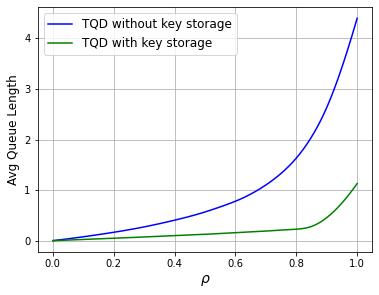

In [56]:
import matplotlib.pyplot as plt
p = np.arange(0,1+prec,prec)
plt.figure(figsize=(6,4.5))
#plt.plot(p,sum_rand, color = 'green', label = 'Rand')
#plt.plot(p,bp, color = 'red', label = 'BP')
plt.plot(xnew,tq, color = 'blue', label = 'TQD without key storage')
plt.plot(xnew,ts, color = 'green', label = 'TQD with key storage')

plt.xlabel("$ρ$",fontsize=14)
plt.ylabel("Avg Queue Length", fontsize=12)
plt.grid()
plt.legend(prop={'size': 12})
#plt.show()
plt.savefig("broadcastSim.png", dpi=600)

In [52]:
w3[17] = 0.2813

In [54]:
from scipy import interpolate
p = np.arange(0,1+prec,prec)
xnew = np.linspace(p.min(), p.max(), 500)
#bp_smooth = interpolate.make_interp_spline(p, w4)
#bp = bp_smooth(xnew)
tq_smooth = interpolate.make_interp_spline(p, w2)
tq = tq_smooth(xnew)
ts_smooth = interpolate.make_interp_spline(p, w3)
ts = ts_smooth(xnew)

In [31]:
from tqdm import tqdm
T=600 
lamb = 0.5

tqd_len = []
Heur_q_len = []
Q_1=[]
Q_2=[]
Q_3=[]
Q_4=[]
Q_5=[]
Q_10=[]
num = 200

y =[10]

for p in tqdm(range(20)):
    for thresh in y:
        #The threshold that determines whether there is minimum that many keys in each edge. Should try thresh = max(c_e)
        w=[]
        for i in tqdm(range(num)):
            arr = np.random.poisson(0.05*p*lamb, T)  #Poisson arrival storing
            key_arr = []
            for i in range(m):
                key_arr.append(np.random.poisson(E[i][3], T))

            w.append(mean(Broadcast_APM(T, arr, key_arr,thresh)))
        r = mean(w)
        if(thresh ==10):
            Q_10.append(r)
        elif(thresh ==2):
            Q_2.append(r)
        elif(thresh ==3):
            Q_3.append(r)
        elif(thresh ==4):
            Q_4.append(r)
        elif(thresh ==5):
            Q_5.append(r)
                
        #apm_mean = mean(Broadcast_APM(T, arr, key_arr,2))
        #rand_mean = mean(HeuristicAPM(T,arr,key_arr,2))



#Thresh_V.append(V_len_arr)
#sum_apm[p] = sum_apm[p] + apm_mean
#sum_heur[p] = sum_heur[p] + rand_mean

 65%|████████████████████████████████████████████████████                            | 130/200 [00:26<00:15,  4.53it/s]


 30%|████████████████████████▎                                                        | 60/200 [00:12<00:29,  4.69it/s]


 96%|████████████████████████████████████████████████████████████████████████████▊   | 192/200 [00:40<00:01,  4.71it/s]


 61%|████████████████████████████████████████████████▊                               | 122/200 [00:26<00:16,  4.63it/s]


 26%|█████████████████████                                                            | 52/200 [00:11<00:34,  4.33it/s]


 92%|█████████████████████████████████████████████████████████████████████████▌      | 184/200 [00:42<00:03,  4.33it/s]


 57%|█████████████████████████████████████████████▌                                  | 114/200 [00:27<00:21,  4.08it/s]


 22%|█████████████████▊                                                               | 44/200 [00:11<00:38,  4.07it/s]


 88%|██████████████████████████████████████████████████████████████████████▍         | 176/200 [00:43<00:06,  3.94it/s]


 53%|██████████████████████████████████████████▍                                     | 106/200 [00:28<00:29,  3.19it/s]


 18%|██████████████▌                                                                  | 36/200 [00:05<00:24,  6.73it/s]


 84%|███████████████████████████████████████████████████████████████████▏            | 168/200 [00:26<00:04,  6.59it/s]


 49%|███████████████████████████████████████▋                                         | 98/200 [00:14<00:15,  6.43it/s]


 14%|███████████▎                                                                     | 28/200 [00:04<00:27,  6.32it/s]


 80%|████████████████████████████████████████████████████████████████                | 160/200 [00:25<00:06,  6.31it/s]


 45%|████████████████████████████████████▍                                            | 90/200 [00:14<00:16,  6.54it/s]


 10%|████████                                                                         | 20/200 [00:03<00:27,  6.47it/s]


 76%|████████████████████████████████████████████████████████████▊                   | 152/200 [00:24<00:08,  5.89it/s]


 41%|█████████████████████████████████▏                                               | 82/200 [00:13<00:20,  5.71it/s]


  6%|████▊                                                                            | 12/200 [00:02<00:39,  4.75it/s]


 72%|█████████████████████████████████████████████████████████▌                      | 144/200 [00:25<00:09,  5.92it/s]


 37%|█████████████████████████████▉                                                   | 74/200 [00:12<00:22,  5.70it/s]


  2%|█▋                                                                                | 4/200 [00:00<00:37,  5.22it/s]


 68%|██████████████████████████████████████████████████████▍                         | 136/200 [00:23<00:10,  5.97it/s]


 33%|██████████████████████████▋                                                      | 66/200 [00:11<00:23,  5.72it/s]


 99%|███████████████████████████████████████████████████████████████████████████████▏| 198/200 [00:36<00:00,  5.85it/s]


 64%|███████████████████████████████████████████████████▏                            | 128/200 [00:22<00:12,  5.68it/s]


 29%|███████████████████████▍                                                         | 58/200 [00:09<00:22,  6.24it/s]


 95%|████████████████████████████████████████████████████████████████████████████    | 190/200 [00:31<00:01,  5.88it/s]


 60%|████████████████████████████████████████████████                                | 120/200 [00:20<00:13,  5.83it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [12:34<00:00, 37.75s/it]


In [35]:
from scipy import interpolate
xnew = np.linspace(p.min(), p.max(), 500)

q1010 = interpolate.make_interp_spline(p, Q_10)
q1010 = q1010(xnew)

In [ ]:
q11 = interpolate.make_interp_spline(p, Q_1)
q11 = q11(xnew)
q22 = interpolate.make_interp_spline(p, Q_2)
q22 = q22(xnew)
q33 = interpolate.make_interp_spline(p, Q_3)
q33 = q33(xnew)
q44 = interpolate.make_interp_spline(p, Q_4)
q44 = q44(xnew)
q55 = interpolate.make_interp_spline(p, Q_5)
q55 = q55(xnew)

In [45]:
from scipy.signal import savgol_filter
w1 = savgol_filter(q11, 151, 2)
w5 = savgol_filter(q55, 151, 2)
w10 = savgol_filter(q1010, 151, 2)

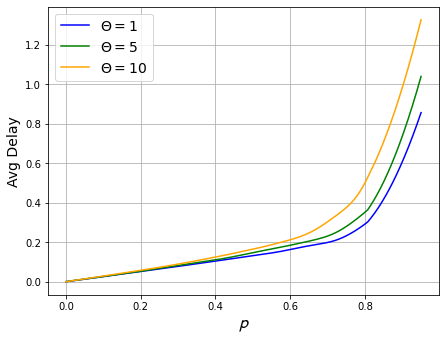

In [54]:
import matplotlib.pyplot as plt
p = np.arange(0,1,0.05)
plt.figure(figsize=(7,5.3))

plt.plot(xnew, w1, color = 'blue', label = '$\Theta = 1$')
#plt.plot(xnew,q22, color = 'blue', label = '$\Theta = 2$')
#plt.plot(xnew, q33, color = 'green', label = '$\Theta = 3$')
#plt.plot(xnew, q44, color = 'orange', label = '$\Theta = 4$')
plt.plot(xnew, w5, color = 'green', label = '$\Theta = 5$')
plt.plot(xnew, w10, color = 'orange', label = '$\Theta = 10$')
plt.xlabel("$\mathcal{p}$", fontsize= 18)
plt.ylabel("Avg Delay", fontsize= 14)
plt.grid()
plt.legend(prop={'size': 14})
plt.show()

## Routes for Randomized Policy

In [112]:
route_set =[]
route_set.append([0,1,4,5])
route_set.append([0,1,3,5])
route_set.append([0,2,3,5])

## Randomized Policy

In [116]:
T=5000

def Randomized(T, arr, k_arr):
    
    Q = np.zeros(m)
    Q_sum = np.zeros(T)
    S = np.zeros(m)
    S_v = np.zeros(m)

    # The Weight-vector would be simply the Q-vector
    W=np.zeros((n, n))

    # Vaiables for recording the statistics 
    sum_Q_len=0
    avg_Q_len= np.zeros((1,T))

    # Number of current packet entered into the network
    Packet_index=0

    # These variables keep track of tree usages
    # Initialize the global tree-base with the "zero-tree"

    Tree_base=np.zeros((n-1,2,1));

    #Number of trees =1
    Num_tree=1;

    # Usage vector keeps count of number of packets entering into the trees
    Usage=np.zeros((1,1));

    Phy_Q = []   #These are m queues for edges 
    for i in range(m):
        obj = Queue()
        Phy_Q.append(obj)

    k = 1 #The constant of proportion between virtual queues and key queues

    for t in range(T):
        a=arr[t]        # Arrival to the source 
        #sum_arr=sum_arr+a

        #Assuming Poisson Key Generation Process
        for i in range(m):
            K = k_arr[i][t]
            S[i] = S[i] + K
            S_v[i] = S_v[i] + K

        #Setting the weight of our graph whose min path is to be computed
        # as the difference of virtual queues and virtual key queues
        G = []
        for i in range(m):
            G.append([E[i][0],E[i][1], Q[i] - (S_v[i]/E[i][3])])

        i = choices(np.arange(3), [0.334, 0.222, 0.444])[0]
        route= route_set[i]
        #Assigning optimal route through dijktras algo(Unicast)
        #routes = dijkstra(G,start,dest)
        #routes = bellmanFord(G,start,dest)
        #print(G)
        #print(routes[dest])
        #Converting route as sequence of nodes to sequence of edges
        route_edge = route_edge_set(route)

        # Virtual Queue Updation - Arrival
        for i in range(len(route_edge)):
            Q[route_edge[i]] = Q[route_edge[i]]+a
            S_v[route_edge[i]] = S_v[route_edge[i]] - a

        #print(a,"Virt Q:", Q, "V.Key:", S_v, "R.Key:", S, "\n")

        for j in range(a):
            p = [0,t,route_edge,0]
            Phy_Q[route_edge[0]].enqueue(p)  

        # Physical Queue Updation

        obj = []
        for i in range(m):
            obj.append(Phy_Q[i].dequeue())  #Assuming service process is limited to 1 packet per slot

        for i in range(m):        
            if(obj[i]!=-1):
                cur_edge = obj[i][2][obj[i][3]]
                next_node = E[cur_edge][1] #Getting next node of packet in the route
                #Key Availability Constraint
                if(S[cur_edge]>0):
                    #Updating distance
                    if (next_node!= dest):
                        next_edge = obj[i][2][obj[i][3]+1]
                        obj[i][3] = obj[i][3]+1
                        Phy_Q[next_edge].enqueue(obj[i])                
                    Q[cur_edge] = Q[cur_edge]-1 #Updating Virtual Queues
                    S[cur_edge] = S[cur_edge]-1 #Updating Real Key Queues
                else:
                    Phy_Q[cur_edge].enqueue(obj[i])

        for i in range(m): 
            Q_sum[t] = Q_sum[t] + Q[i]

        Q_sum[t] = Q_sum[t]/m
        
    return Q_sum
